In [1]:
# local settings

import os, sys

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

current = os.path.dirname(os.path.realpath("*.ipynb"))
parent = os.path.dirname(current)
sys.path.append(parent)
# %cd ..

In [2]:
# online settings (papermill execution)

plt.rcParams['figure.dpi'] = 300

In [3]:
# Parameters

num_epochs = 100
no_pca = False
noise_scale = 4

max_grad_norm = 4
lot_size = 600
hidden_size = 1000
q = None

In [4]:
from mnist import *

In [ ]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)

print(f'Using device: {device}')

# data loaders
train_data = datasets.MNIST(
    root='data', download=True, train=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(
    root='data', download=True, train=False, transform=transforms.ToTensor())

if not no_pca:
    # apply PCA to the dataset (as done in the paper)
    X_train = train_data.data.reshape(len(train_data), -1)
    X_test = test_data.data.reshape(len(test_data), -1)

    A = torch.cat([X_train, X_test]).float()
    pca_dim = 60
    _, _, V = torch.pca_lowrank(A, q=pca_dim)

    res = torch.matmul(A, V)

    X_train_pca_tensor = res[:60000]
    X_test_pca_tensor = res[60000:]
    y_train = train_data.targets
    y_test = test_data.targets

    # create torch datasets
    train_data = TensorDataset(X_train_pca_tensor, y_train)
    test_data = TensorDataset(X_test_pca_tensor, y_test)

# training settings
lot_size = lot_size if q is None else int(q * len(train_data))  # (L)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=lot_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=lot_size, shuffle=False)

model = LinearNet(in_features=784 if no_pca else pca_dim, hidden=hidden_size).to(device)
# model = ConvNet().to(device)
accountant = accountants.ModifiedMomentsAccountant(noise_scale, q=lot_size / len(train_data))

# loss function
criterion = nn.CrossEntropyLoss()

In [6]:
from collections import defaultdict

all_logger = defaultdict(dict)

In [7]:
# differentially private optimizer
optimizer = optim.PIAdam(model.named_parameters(), lot_size, noise_scale=noise_scale,
                         max_grad_norm=max_grad_norm)

logger = {'loss': [], 'total_loss': [], 'accuracy': [], 'total_accuracy': [], 'total_val_accuracy': [], 'epsilon': []}

train_dp_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, device=device,
               logger=logger, accountant=accountant)

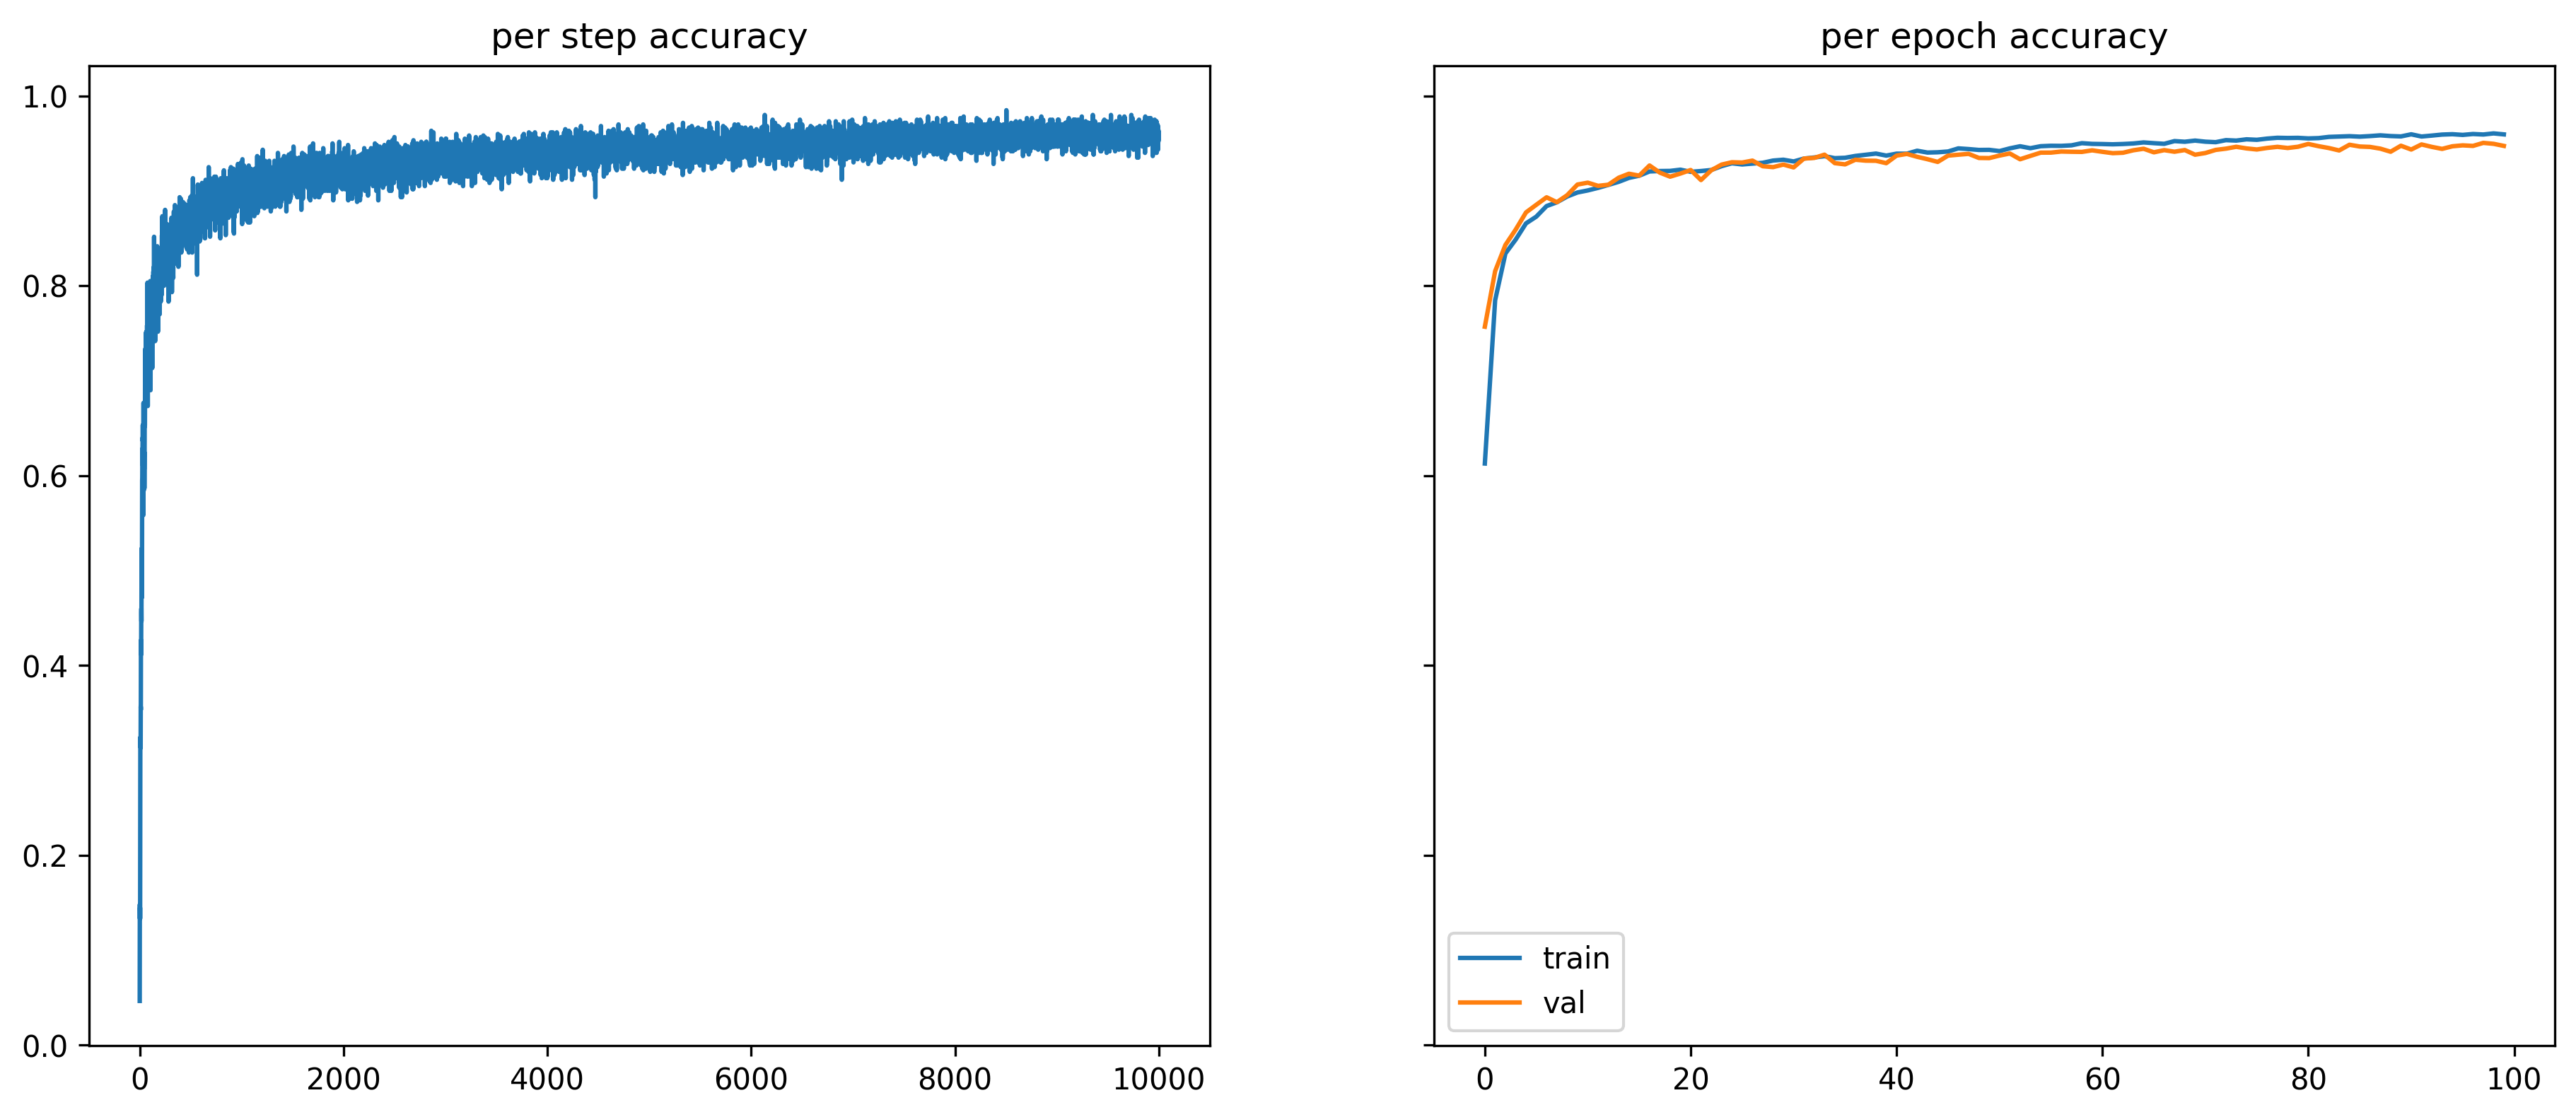

In [8]:
# plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

ax[0].plot(logger['accuracy'])
ax[0].set_title('per step accuracy')

ax[1].plot(logger['total_accuracy'], label='train')
ax[1].set_title('per epoch accuracy')
ax[1].plot(logger['total_val_accuracy'], label='val')
ax[1].legend()
plt.show()

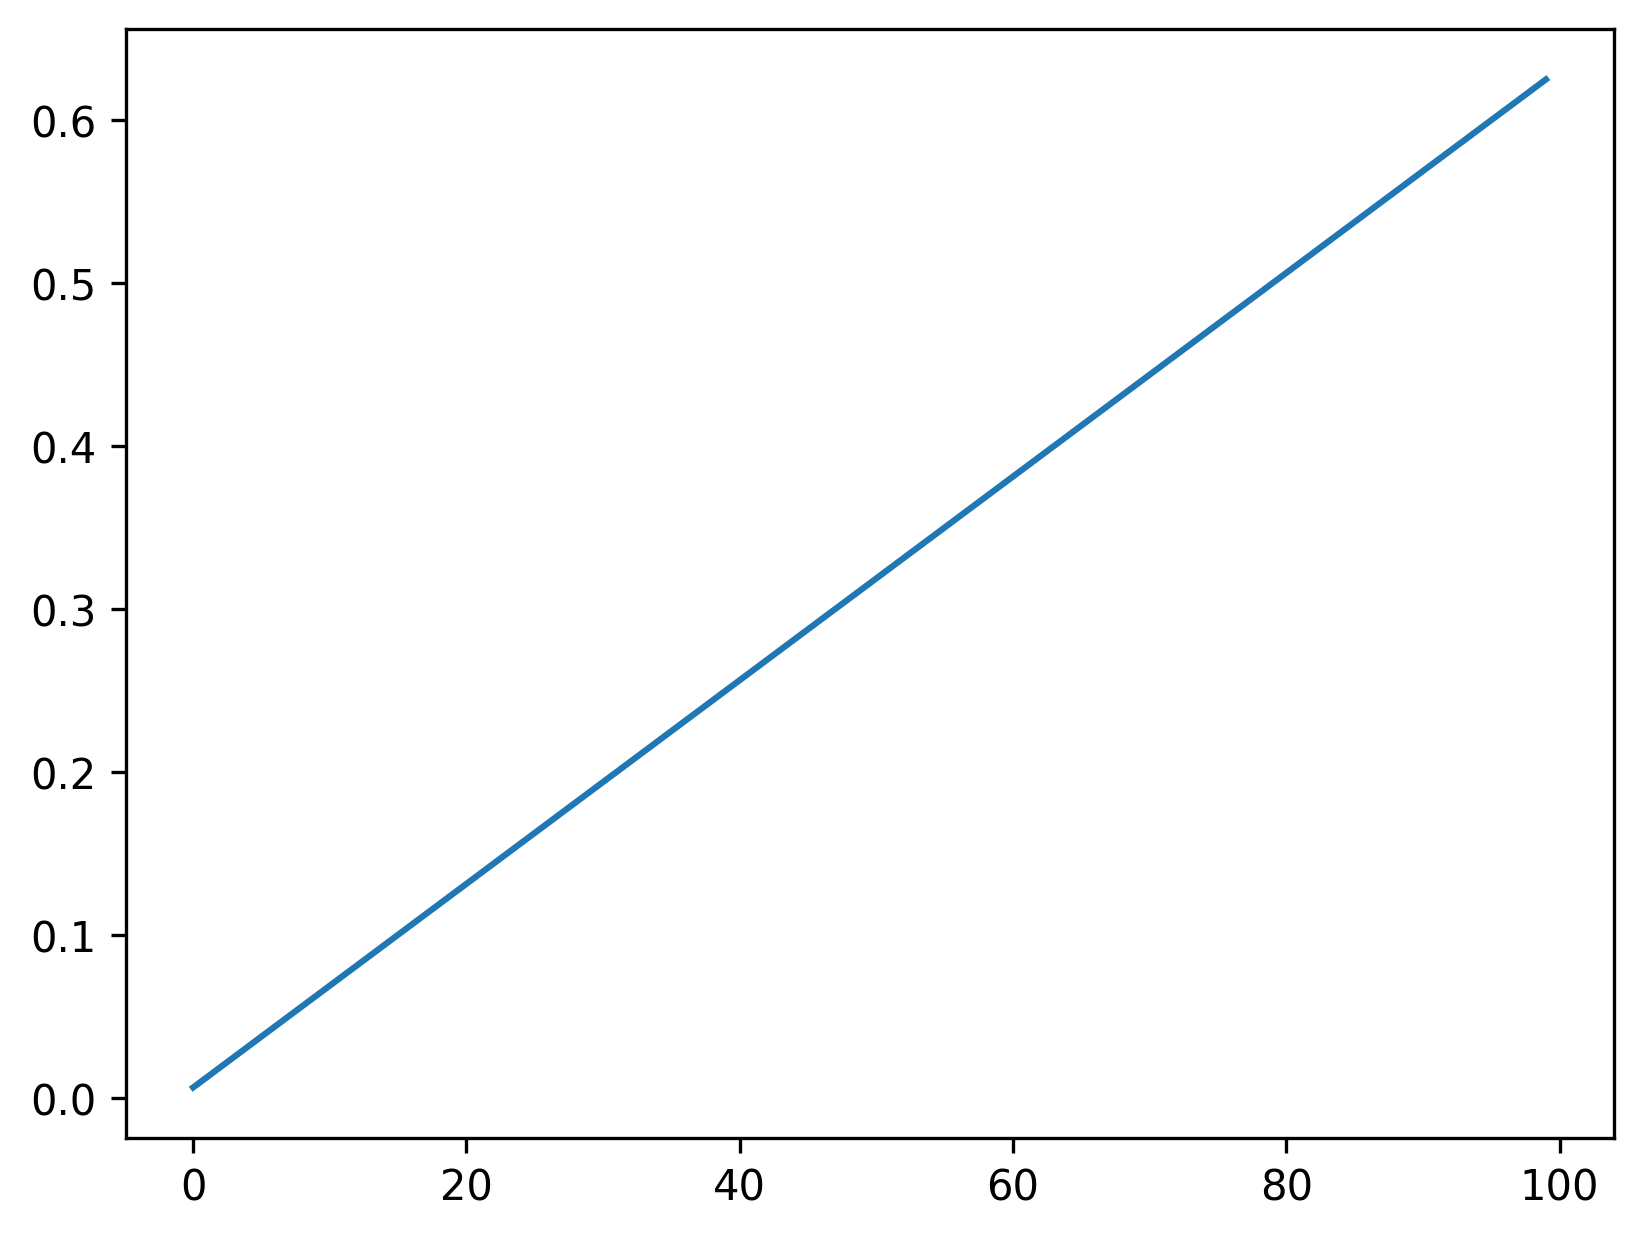

In [10]:
# plot epsilon

plt.plot(logger['epsilon'])